In [1]:
import pandas as pd
import numpy as np
from scipy import spatial
from scipy.cluster import hierarchy
from scipy.spatial.distance import euclidean
import random
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MiniBatchKMeans, Birch
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import warnings

# Etap III - Modelowanie

Wstępny plan działania:
* próba redukcji wymiarów PCA, TSNE
* prezentacja danych oryginalnych na dwu-/trzy- wymiarowej przestrzeni
* Próba porównania algorytmów miarami D-B, Silhouette, C-H
* Jeśli dobrze zrozumiemy działanie algorytmów (liczbę klastrów), próba zmierzenia wyników algorytmów klasteryzujących z labelami przy pomocy miar je uwzględniających

## Wczytanie danych

In [2]:
orig_data = pd.read_csv('AllBooks_baseline_DTM_Labelled.csv', index_col = 0)
df_tfidf = pd.read_csv('df_tfidf.csv', header = None) #Macierz nie miala naglowka
df_glove_remove_1 = pd.read_csv('df_glove_remove_1.csv', index_col = 0)
df_glove_remove_2 = pd.read_csv('df_glove_remove_2.csv', index_col = 0)

Niech nazwy wierszy ramki orig_data zawierają nazwę księgi pochodzenia.

In [3]:
orig_data.index = [i.split('_')[0] for i in orig_data.index]
np.unique(orig_data.index)

array(['BookOfEccleasiasticus', 'BookOfEcclesiastes', 'BookOfProverb',
       'BookOfWisdom', 'Buddhism', 'TaoTeChing', 'Upanishad', 'YogaSutra'],
      dtype=object)

## Redukcja wymiarów - PCA i tSNE

Zacznijmy redukcję wymiarów oryginalnej ramki. Przed zastosowaniem metod redukujących istotna jest normalizacja zmiennych: MinMaxScaler + LogNormalizacja (preprocessing nie jest wymagany na naszych przygotowanych ramkach). Na wyjściu prezentowany jest wykres przedstawiający działanie dwóch metod: PCA oraz TSNE.

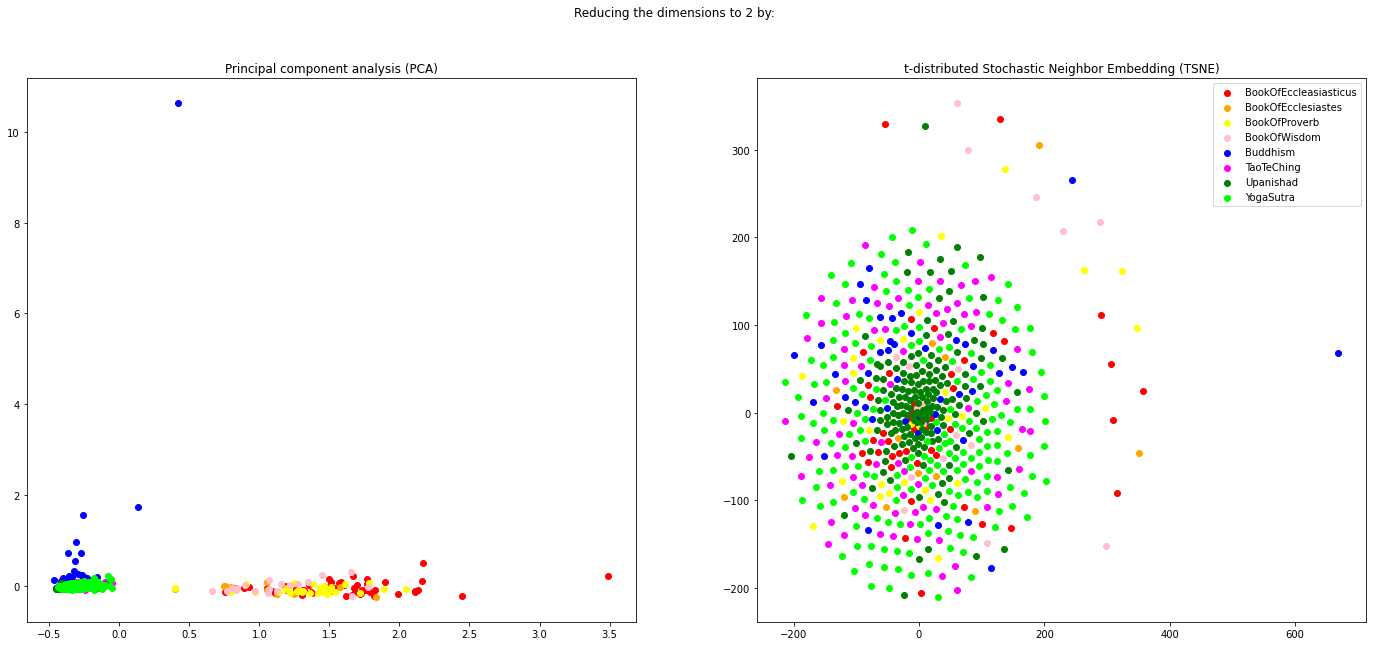

In [4]:
pca2 = PCA(2, random_state=10)
tsne2 = TSNE(2, random_state=98)
def plot_2d(data, labels, reducing_tool1 = pca2, reducing_tool2 = tsne2, log_transform = True, min_max = True):
    '''
    Prezentuje dwa wykresy wizualizujące efekt działań PCA oraz TSNE - wymaga podania prawdziwych etykiet
    '''
    if min_max:
        scaler = MinMaxScaler()
        data = pd.DataFrame(scaler.fit_transform(data))
    if log_transform:
        transformer = FunctionTransformer(np.log1p, validate=True)
        data = transformer.transform(data)
    trans_data1 = reducing_tool1.fit_transform(data)
    trans_data2 = reducing_tool2.fit_transform(data)
    color_dict = {'BookOfEccleasiasticus': 'red', 'BookOfEcclesiastes': 'orange', 'BookOfProverb': 'yellow', 'BookOfWisdom': 'pink',
                'Buddhism': 'blue', 'TaoTeChing': 'magenta', 'Upanishad': 'green', 'YogaSutra': 'lime'}
    fig, axes = plt.subplots(1, 2, figsize = (24, 10))
    fig.suptitle('Reducing the dimensions to 2 by:')
    for book in np.unique(labels):
        ind = np.where(labels == book)
        axes[0].scatter(trans_data1[ind, 0],trans_data1[ind, 1], color = color_dict[book], label= book)
        axes[1].scatter(trans_data2[ind, 0],trans_data2[ind, 1], color = color_dict[book], label= book)
    axes[0].set_title('Principal component analysis (PCA)')
    axes[1].set_title('t-distributed Stochastic Neighbor Embedding (TSNE)')
    plt.legend()
    plt.show()


plot_2d(orig_data, orig_data.index)

Na oryginalnej ramce nie wygląda to ciekawie w dwóch wymiarach. Spróbujmy prezentacji w trzech:

In [5]:
pca3 = PCA(3, random_state=10)
tsne3 = TSNE(3, random_state=98)
def plot_3d(data, labels, title, reducing_tool1 = pca3, reducing_tool2 = tsne3, min_max = True, log_transform = True):
    '''
    Podobnie jak poprzednia funkcja, ta prezentuje efekty działania PCA i TSNE, jednak w trzech wymiarach. 
    '''
    if min_max:
        scaler = MinMaxScaler()
        data = pd.DataFrame(scaler.fit_transform(data))
    if log_transform:
        transformer = FunctionTransformer(np.log1p, validate=True)
        data = transformer.transform(data)
    color_dict = {'BookOfEccleasiasticus': 'red', 'BookOfEcclesiastes': 'orange', 'BookOfProverb': 'yellow', 'BookOfWisdom': 'pink',
                'Buddhism': 'blue', 'TaoTeChing': 'magenta', 'Upanishad': 'green', 'YogaSutra': 'lime'}
    transf_data = reducing_tool1.fit_transform(data)
    fig = make_subplots(1, 2,
                        specs=[[{'type': 'scene'}, {'type': 'scene'}]],
                        column_titles = ['Principal component analysis (PCA)', 't-distributed Stochastic Neighbor Embedding (TSNE)'])
    df = pd.DataFrame(transf_data)
    df['labels'] = labels
    fig.add_trace(go.Scatter3d(x = df.iloc[:,0], y = df.iloc[:,1], z = df.iloc[:,2],
                                 mode = 'markers', marker = dict(size = 1.5, color = labels.map(color_dict))), row = 1, col = 1)
    transf_data2 = reducing_tool2.fit_transform(data)
    df2 = pd.DataFrame(transf_data2)
    df2['labels'] = labels
    fig.add_trace(go.Scatter3d(x = df2.iloc[:,0], y = df2.iloc[:,1], z = df2.iloc[:,2],
                                 mode = 'markers', marker = dict(size = 1.5, color = labels.map(color_dict))), row = 1, col = 2)
    fig.update_layout(title = title + ': Reducing the dimensions to 3 by:', showlegend = False)
    fig.show()

plot_3d(orig_data, orig_data.index, "Original data")

Warto zwrócić uwagę, że TSNE działa trochę dłużej od PCA.

In [6]:
plot_3d(df_tfidf, orig_data.index, "TF_IDF frame", min_max = False, log_transform = False)

In [7]:
plot_3d(df_glove_remove_1, orig_data.index, "Frame with weighted average vector", min_max = False, log_transform = False)

In [8]:
plot_3d(df_glove_remove_2, orig_data.index, "Frame with concatenated GloVe vector", min_max = False, log_transform = False)

Niestety, działanie TSNE w trzech wymiarach nie skutkowało rozdzieleniem klastrów dla którejkolwiek z ramek. Subiektywnie można stwierdzić, że dla 8 powyższych prób, najlepiej spisał się PCA na ramce po transformacji TF_IDF.

# Wstęp do DBSCAN

Algorytm DBSCAN wyróżnia spośród innych sposobów klasteryzacji determinizm - ponowne wywołanie metody o tych samych parametrach wejściowych na tych samych danych zawsze zwróci te same wyniki - oczywiście nie chodzi tu o żaden random state. Stworzenie modelu DBSCAN wymaga ustalenia dwóch kluczowych parametrów: `eps` oraz `min_samples`.
Korzystając z informacji zawartych w artykule [Jörg Sander, Martin Ester, Hans-Peter Kriegel, and Xiaowei Xu. 1998. Density-based clustering in spatial databases: The algorithm GDBSCAN and its applications. Data Mining and Knowledge Discovery2, 2 (1998), 169–194](https://link.springer.com/article/10.1023/A:1009745219419). (artykuł płatny - cytowanie za [Schubert, Erich & Sander, Jörg & Ester, Martin & Kriegel, Hans & Xu, Xiaowei. (2017). DBSCAN revisited, revisited: Why and how you should (still) use DBSCAN](https://dl.acm.org/doi/pdf/10.1145/3068335)]. ) zdecydowałem się na zastosowanie arbitralnego sposobu ustawienia tych parametrów:
* min_samples = 2∗wymiar danych
* eps = odległość, względem której większość (tzn. 95%) spośród k-tych sąsiadów dla poszczególnych obserwacji jest bliżej. k jest obliczane przy pomocy formuły 2∗ wymiar danych − 1

Oczywiście ustalenie takich parametrów jest niemożliwe na całej ramce danych, zatem przeprowadzone testy będą sprawdzały najkorzystniejszą liczbę wymiarów po ich redukcji do kilku(nastu).

**Uwaga, ze względu m.in. na dość mozolne obliczanie odległości pomiędzy punktami, funkcje działają długo**

In [9]:
def test_DBSCAN(data, reducing_tool, n_components, min_max = False, log_transform = False):
    '''
    Testuj algorytm DBSCAN ze wzgledu na rozne parametry:
    reducing_tool - 'PCA' bądź 'TSNE',
    n_components - liczba wymiarów do ilu dane mają zostać sprowadzone
    min_max i log_transform - etapy preprocessingu przed redukcją wymiarów

    Funkcja prezentuje etykiety będące efektem działania DBSCAN oraz przetransformowaną ramkę danych po redukcji (i ew. preprocessingu)
    Parametry używane bezpośrednio przez DBSCAN są opisane powyżej
    '''
    def calculate_kn_distance(X,k = None):
        '''
        Oblicza euklidesową odległość do k-ego sąsiada dla każdej z obserwacji i zwraca je jako listę
        '''
        if k is None:
            k = 2 * X.shape[1] - 1
        if k > X.shape[0]:
            warnings.warn('Could not calculate the distance')
            return
        kn_distance = []
        eucl_dist = np.array([[0.0]*X.shape[0] for _ in range(X.shape[0])])
        for i in range(X.shape[0]):
            ref_val = X.iloc[i,:]
            for j in range(i+1, X.shape[0]):
                vec_dist = euclidean(ref_val, X.iloc[j,:])
                eucl_dist[i, j] = vec_dist
                eucl_dist[j, i] = vec_dist
        for i in range(len(eucl_dist)):
            kn_distance.append(sorted(eucl_dist[i,:])[k])
        return kn_distance

    if min_max:
        scaler = MinMaxScaler()
        data = pd.DataFrame(scaler.fit_transform(data))
    if log_transform:
        transformer = FunctionTransformer(np.log1p, validate=True)
        data = transformer.transform(data)
    if reducing_tool == 'PCA':
        tool = PCA(n_components=n_components, random_state=10)
    elif reducing_tool == 'TSNE':
        tool = TSNE(n_components=n_components, random_state=10) if n_components < 4 else TSNE(n_components=n_components, method = 'exact', random_state=10)
    else:
        raise ValueError("Wrong reducing_tool")
    transf_data = pd.DataFrame(tool.fit_transform(data))

    dist = calculate_kn_distance(transf_data, 2 * n_components -1)
    eps = np.percentile(dist, 95)
    min_samples = 2 * n_components
    model = DBSCAN(eps = eps, min_samples = min_samples)
    labels = model.fit_predict(transf_data)
    return labels, transf_data

def test_dimensions_DBSCAN(data, reducing_tool, score, declared_range, true_labels = None, min_max = False, log_transform = False):
    '''
    Funkcja, korzystając z powyższych, oblicza wartości podanego indeksu score (należy zadbać by
    true_labels zawierało prawdziwe etykiety wtw. gdy funkcja oceniająca używa oryginalnych etykiet) dla każdej z wartości podanej w zakresie declared_range
    Uwaga: algorytm DBSCAN lubi zwracać tylko jedną etykietę bądź jedną etykietę oraz -1, które oznaczają 'szum' danych. Być może to kwestia
    źle dobranych parametrów, jednak nie satysfakcjonuje nas taka ewentualność
    Na wyjściu dostajemy wykres z wynikami (wartość score oraz liczba klastrów) oraz 4 listy:
    indexes - lista indeksów, dla których z powodzeniem przeprowadzono klasteryzacje, tzn. takich gdzie zwrocono co najmniej 2 labele - wazne!
    scores - lista współczynników obliczonych dla każdej z iteracji które się powiodły 
    labels - lista np.arrayów zwracanych przez udane klasteryzacje, zawierajacych przyporzadkowane etykietki
    datasets - lista ramek danych, ktore wyszly po przetworzeniu

    '''
    scores=[0 for i in declared_range]
    indexes = []
    labels = []
    datasets = []
    clusters = [0 for i in declared_range]
    j = 0
    for i in declared_range:
        print(f'Testing {i} dimensions')
        label, data = test_DBSCAN(df_tfidf, reducing_tool, i, min_max = min_max, log_transform = log_transform)
        n_clusters = len(np.unique(label)) if -1 not in label else len(np.unique(label)) - 1 
        if n_clusters > 1:
            labels.append(label)
            datasets.append(data)
            clusters[j]=n_clusters
            if true_labels is None:
                scores[j] = score(data, label)
            else:
                scores[j] = score(true_labels, label)
            indexes.append(i)
            
        else:
            warnings.warn(f'One label (excl. noise) returned for {i} dimensions')
        j+=1
    fig, ax = plt.subplots(1, 2)
    ax[0].bar(declared_range, scores, color = 'royalblue')
    ax[0].set_ylabel("Score", color = "blue")
    #ax.tick_params(axis = 'y', labelcolor = 'blue')
    ax[0].set_xlabel('Dimensions')
    ax[0].set_ylim((0, 1))
    #ax2 = ax.twinx()
    ax[1].bar(declared_range, clusters, color = 'gray')
    ax[1].set_ylabel('Number of clusters', color = 'gray')
    #ax2.tick_params(axis = 'y', labelcolor = 'gray')
    #plt.xticks([i for i in declared_range])
    fig.suptitle('Score + Number of clusters')
    plt.show()
    return indexes, scores, labels, datasets


Testing 2 dimensions
Testing 3 dimensions


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: UserWarning:

One label (excl. noise) returned for 3 dimensions



Testing 4 dimensions


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: UserWarning:

One label (excl. noise) returned for 4 dimensions



Testing 5 dimensions


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: UserWarning:

One label (excl. noise) returned for 5 dimensions



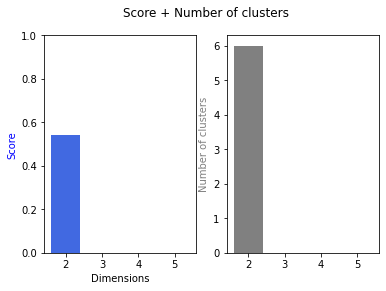

In [0]:
warnings.filterwarnings('default')
_, s, _, _ = test_dimensions_DBSCAN(df_tfidf, 'PCA', silhouette_score, range(2, 6))

Testing 2 dimensions


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: UserWarning:

One label (excl. noise) returned for 2 dimensions



Testing 3 dimensions


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: UserWarning:

One label (excl. noise) returned for 3 dimensions



Testing 4 dimensions


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: UserWarning:

One label (excl. noise) returned for 4 dimensions



Testing 5 dimensions


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: UserWarning:

One label (excl. noise) returned for 5 dimensions



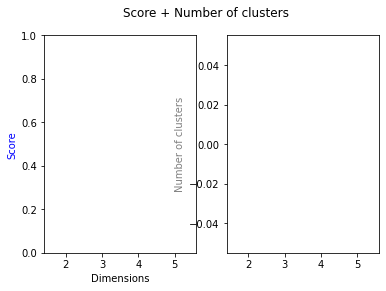

In [0]:
_, _, _, _ = test_dimensions_DBSCAN(df_tfidf, 'TSNE', silhouette_score, range(2, 6))

Testing 2 dimensions
Testing 3 dimensions


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: UserWarning:

One label (excl. noise) returned for 3 dimensions



Testing 4 dimensions


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: UserWarning:

One label (excl. noise) returned for 4 dimensions



Testing 5 dimensions


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: UserWarning:

One label (excl. noise) returned for 5 dimensions



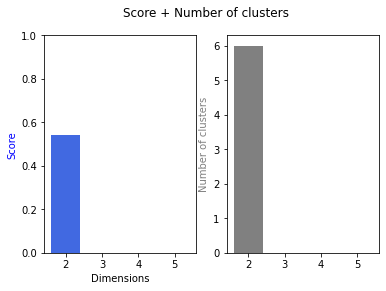

In [0]:
_, _, _, _ = test_dimensions_DBSCAN(df_glove_remove_1, 'PCA', silhouette_score, range(2, 6))

Testing 2 dimensions
Testing 3 dimensions


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: UserWarning:

One label (excl. noise) returned for 3 dimensions



Testing 4 dimensions


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: UserWarning:

One label (excl. noise) returned for 4 dimensions



Testing 5 dimensions


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: UserWarning:

One label (excl. noise) returned for 5 dimensions



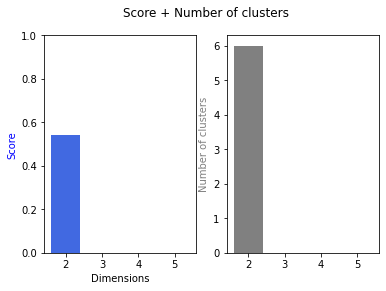

In [0]:
_, _, _, _ = test_dimensions_DBSCAN(df_glove_remove_2, 'PCA', silhouette_score, range(2, 6))

Niestety - drobny zawód. DBSCAN zwraca więcej niż jeden klaster (i to aż 6) dla dwóch wymiarów - niezależnie od narzędzia redukującego. Dla PCA wyniki są znacznie wyższe.

Sprawdźmy w takim razie jak spiszą się inne, bardziej typowe algorytmy.
Dla każdego z nich można wyraźnie określić liczbę klastrów do podziału (choć oczywiście dla aglomeracyjnego nie trzeba). W skład testowanych metod wchodzą:
* K Means
* Mini Batch K Means
* Birch
* Agglomerative Clustering - różne połączenia:
** Warda
** kompletne
** pojedyncze

Efekt prac każdej z metod może zostać zmierzony przy pomocą wybranej miary dla pewnego zakresu określanego jako parametr funkcji.

In [10]:
def test_algorithms(data, n_clusters_range, score, true_labels = None, plot = True):
    '''
    Funkcja testująca efektywność działania algorytmów klasteryzujących dla różnych liczb klastrów określanych w n_clusters_range
    score - funkcja do oceny efektywności (należy zadbać by true_labels zawierało prawdziwe etykiety wtw. gdy funkcja oceniająca używa oryginalnych etykiet)
    plot - czy prezentować wykresy?
    Funkcja zwraca słownik zawierający wszystkie obliczone oceny pracy algorytmu w formie słownika, gdzie klucze to nazwy algorytmów a wartości to lista ocen
    '''
    kmeans_scores = []
    minibatch_scores = []
    agg_ward_scores = []
    agg_complete_scores = []
    agg_single_scores = []
    birch_scores = []
    for k in n_clusters_range:
        print(f'Calculating {k} clusters')
        kmeans_model = KMeans(n_clusters=k, random_state = 101)
        minibatch_model = MiniBatchKMeans(n_clusters=k, random_state = 523)
        agg_ward_model = AgglomerativeClustering(n_clusters = k, linkage = 'ward')
        agg_complete_model = AgglomerativeClustering(n_clusters = k, linkage = 'complete')
        agg_single_model = AgglomerativeClustering(n_clusters = k, linkage = 'single')
        birch_model = Birch(n_clusters = k)
        kmeans_labels = kmeans_model.fit_predict(data)
        minibatch_labels = minibatch_model.fit_predict(data)
        agg_ward_labels = agg_ward_model.fit_predict(data)
        agg_complete_labels = agg_complete_model.fit_predict(data)
        agg_single_labels = agg_single_model.fit_predict(data)
        birch_labels = birch_model.fit_predict(data)
        if true_labels is None:
            kmeans_scores.append(score(data, kmeans_labels))
            minibatch_scores.append(score(data, minibatch_labels))
            agg_ward_scores.append(score(data, agg_ward_labels))
            agg_complete_scores.append(score(data, agg_complete_labels))
            agg_single_scores.append(score(data, agg_single_labels))
            birch_scores.append(score(data, birch_labels))
        else:
            kmeans_scores.append(score(true_labels, kmeans_labels))
            minibatch_scores.append(score(true_labels, minibatch_labels))
            agg_ward_scores.append(score(true_labels, agg_ward_labels))
            agg_complete_scores.append(score(true_labels, agg_complete_labels))
            agg_single_scores.append(score(true_labels, agg_single_labels))
            birch_scores.append(score(true_labels, birch_labels))
    if plot:
        _, axes = plt.subplots(2, 3, figsize = (20, 10), sharey = True)
        plt.suptitle('Performance score calculated on different clustering methods and number of clusters')
        axes[0,0].bar(n_clusters_range, kmeans_scores, color = 'blue', edgecolor = 'black')
        axes[0,1].bar(n_clusters_range, minibatch_scores, color = 'cyan', edgecolor = 'black')
        axes[0,2].bar(n_clusters_range, birch_scores, color = 'green', edgecolor = 'black')
        axes[1,0].bar(n_clusters_range, agg_complete_scores, color = 'orange', edgecolor = 'black')
        axes[1,1].bar(n_clusters_range, agg_single_scores, color = 'yellow', edgecolor = 'black')
        axes[1,2].bar(n_clusters_range, agg_ward_scores, color = 'red', edgecolor = 'black')
        axes[0,0].set_title('KMeans score')
        axes[0,1].set_title('Mini Batch KMeans score')
        axes[0,2].set_title('Birch score')
        axes[1,0].set_title('Agglomerative Complete score')
        axes[1,1].set_title('Agglomerative Single score')
        axes[1,2].set_title('Agglomerative Ward score')
        for axe in axes:
            for ax in axe:
                ax.set_xlabel('Clusters')
                ax.set_ylabel('Score')
        plt.ylim(min(0, plt.ylim()[0]), 1.0)
        plt.show()
    return {'KMeans': kmeans_scores, 'MiniBatch': minibatch_scores, 'Birch': birch_scores, 'Agg_Complete': agg_complete_scores,
            'Agg_Single': agg_single_scores, 'Agg_Ward': agg_ward_scores}



Ramka df_tfidf - z racji rozmiaru praca funkcji na tej ramce dziala znacznie dluzej niż na pozostałych.


Ramka Tfidf i silhouette score dla roznej liczby klastrow:

Calculating 2 clusters
Calculating 3 clusters
Calculating 4 clusters
Calculating 5 clusters
Calculating 6 clusters
Calculating 7 clusters
Calculating 8 clusters


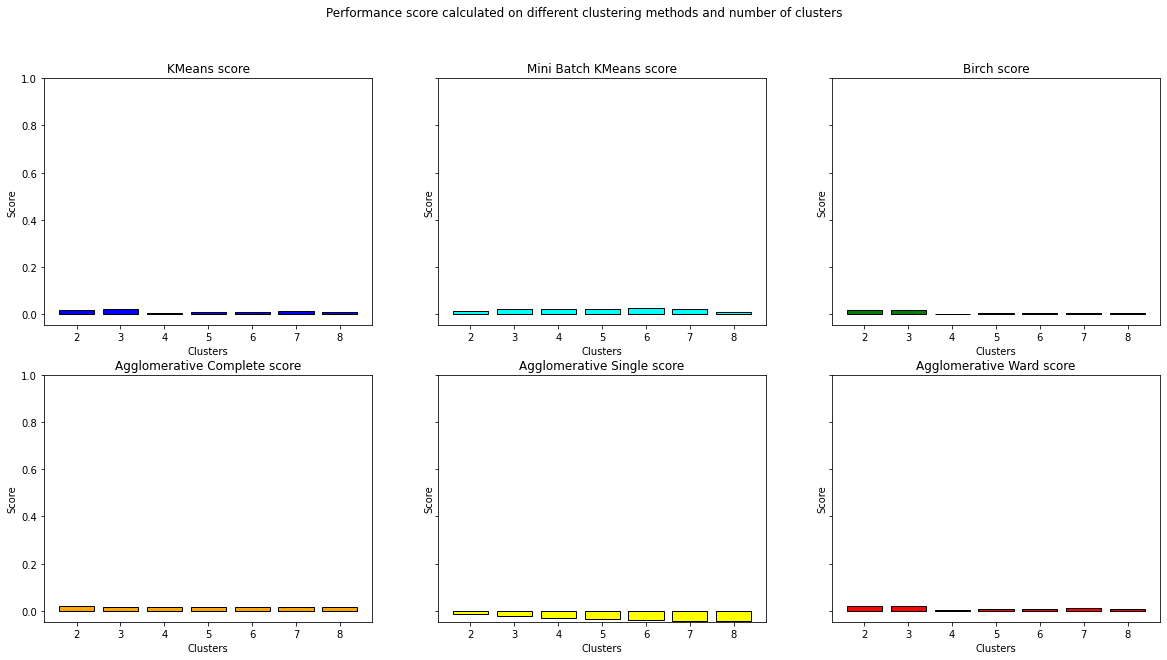

In [0]:
_ = test_algorithms(df_tfidf, range(2, 9), silhouette_score)

$1.$ ramka Glove i silhouette dla różnych liczb klastrów:

Calculating 2 clusters
Calculating 3 clusters
Calculating 4 clusters
Calculating 5 clusters
Calculating 6 clusters
Calculating 7 clusters
Calculating 8 clusters


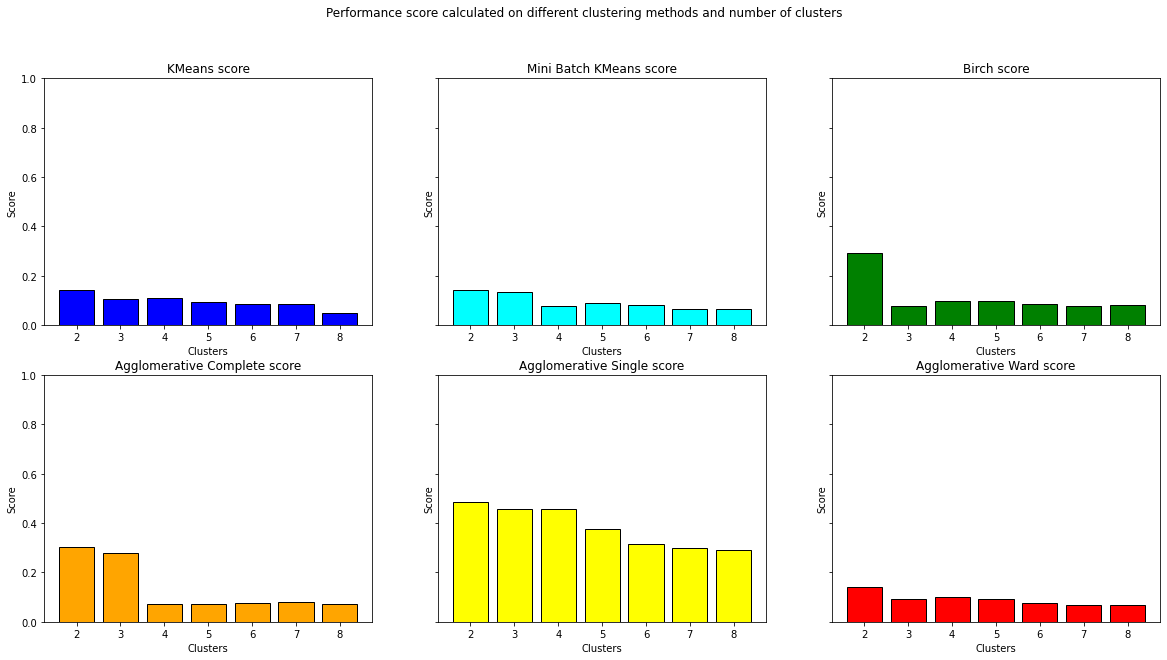

In [0]:
_ = test_algorithms(df_glove_remove_1, range(2, 9), silhouette_score)

$2.$ ramka Glove i miary silhouette dla różnych liczb klastrów:

Calculating 2 clusters
Calculating 3 clusters
Calculating 4 clusters
Calculating 5 clusters
Calculating 6 clusters
Calculating 7 clusters
Calculating 8 clusters


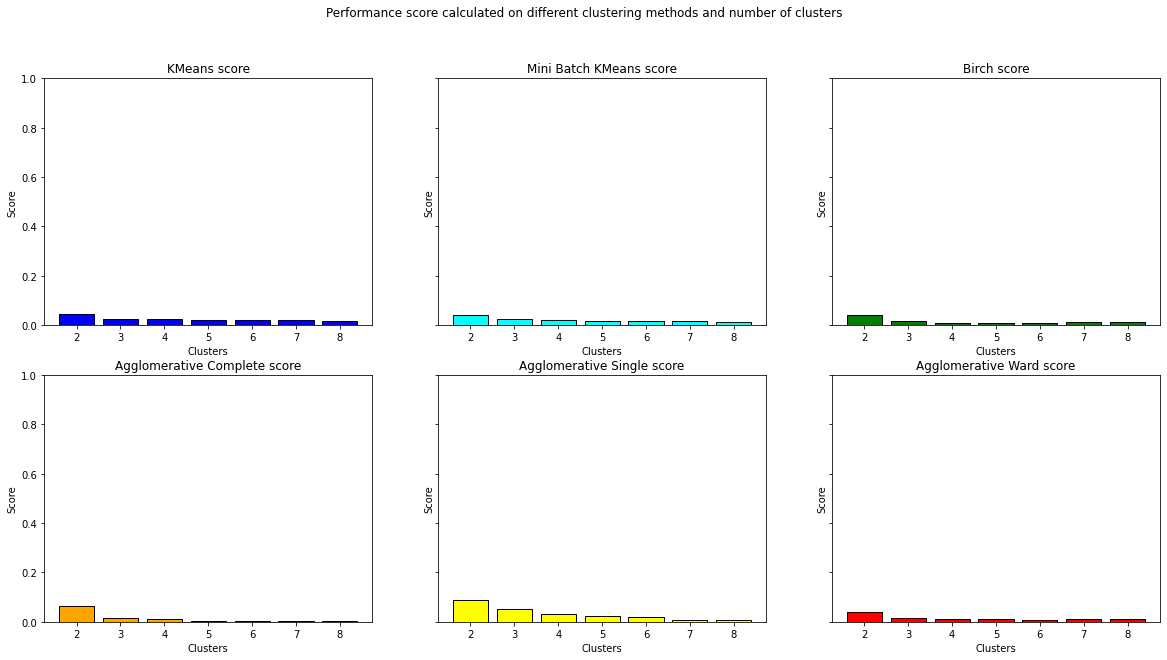

In [0]:
_ = test_algorithms(df_glove_remove_2, range(2, 9), silhouette_score)

Niestety najczęściej miara Silhouette szoruje nam po dnie - za dokumentacją, wyniki w okolicach 0 oznacza, że klastry tak naprawdę nachodzą na siebie. Najlepszy wynik osiągnął algorytm `Agglomerative Single` na ramce `df_glove_remove_1` - ok. 0.5


## Klasteryzacja po redukcji wymiarów

Sprawdźmy korzyści z redukcji wymiarów.

In [11]:
def test_reducing_dim(df, n_dim_range, reducing_tool, clusters_range, score, true_labels = None, plot = True ):
    '''
    Funkcja do testowania redukcji wymiarów oraz różnej liczby klastrów (zakres definiowany parametrem n_dim_range),
    ponadto wizualizująca poszczególne działania algorytmów.
    Efektem jej działania jest grafika składająca się z 6 okienek dla każdego z algorytmu. Wykresu należy czytać następująco:
    oś x to liczba wymiarów do ilu sprowadzono ramkę danych wraz z zaznaczoną najlepszą wartością jako etykieta na legendzie,
    oś y to maksymalna wartość zadanej miary dla określonej liczby wymiarów. Co więcej, w tytule znajduje się informacja
    na ile klastrów dane zostały podzielone w najbardziej efektywnym przypadku.

    '''
    kmeans = np.array([[0.0, 0] for i in n_dim_range])
    minibatch = np.array([[0.0, 0] for i in n_dim_range])
    birch = np.array([[0.0, 0] for i in n_dim_range])
    agg_complete = np.array([[0.0, 0] for i in n_dim_range])
    agg_single = np.array([[0.0, 0] for i in n_dim_range])
    agg_ward = np.array([[0.0, 0] for i in n_dim_range])
    j = 0
    for i in n_dim_range:
        print(f'Testing {i} dimensions')
        if reducing_tool == 'PCA':
            tool = PCA(i, random_state=10)
        elif reducing_tool == 'TSNE':
            tool = TSNE(i, random_state=10) if i < 4 else TSNE(i, method = 'exact', random_state=10)
        else:
            raise ValueError(f'Wrong reducing_tool {reducing_tool}. Should be one of "PCA", "TSNE"')
        data = pd.DataFrame(tool.fit_transform(df))
        scores_dict = test_algorithms(data, clusters_range, score, true_labels, False)
        kmeans[j,:] = [max(scores_dict['KMeans']), clusters_range[np.argmax(scores_dict['KMeans'])]]
        minibatch[j,:] = [max(scores_dict['MiniBatch']), clusters_range[np.argmax(scores_dict['MiniBatch'])]]
        birch[j,:] = [max(scores_dict['Birch']), clusters_range[np.argmax(scores_dict['Birch'])]]
        agg_complete[j,:] = [max(scores_dict['Agg_Complete']), clusters_range[np.argmax(scores_dict['Agg_Complete'])]]
        agg_single[j,:] = [max(scores_dict['Agg_Single']), clusters_range[np.argmax(scores_dict['Agg_Single'])]]
        agg_ward[j,:] = [max(scores_dict['Agg_Ward']), clusters_range[np.argmax(scores_dict['Agg_Ward'])]]
        j += 1
    if plot:
        fig, axes = plt.subplots(2, 3, figsize = (20, 10), sharey = True)
        fig.suptitle(f'Best score for different number of dimensions ({reducing_tool}) and clusters (best scores for dimensions presented)')
        axes[0, 0].bar(n_dim_range, kmeans[:,0], color = 'blue', edgecolor = 'black')
        axes[0, 1].bar(n_dim_range, minibatch[:,0], color = 'cyan', edgecolor = 'black')
        axes[0, 2].bar(n_dim_range, birch[:,0], color = 'green', edgecolor = 'black')
        axes[1, 0].bar(n_dim_range, agg_complete[:,0], color = 'orange', edgecolor = 'black')
        axes[1, 1].bar(n_dim_range, agg_single[:,0], color = 'yellow', edgecolor = 'black')
        axes[1, 2].bar(n_dim_range, agg_ward[:,0], color = 'red', edgecolor = 'black')
        axes[0,0].set_title(f'KMeans best scores. N of clusters of best choice: {int(kmeans[np.argmax(kmeans[:,0]), 1])}')
        axes[0,1].set_title(f'Mini Batch KMeans best scores. N of clusters of best choice: {int(minibatch[np.argmax(minibatch[:,0]), 1])}')
        axes[0,2].set_title(f'Birch best scores. N of clusters of best choice: {int(birch[np.argmax(birch[:,0]), 1])}')
        axes[1,0].set_title(f'Agglomerative Complete best scores. N of clusters of best choice: {int(agg_complete[np.argmax(agg_complete[:,0]), 1])}')
        axes[1,1].set_title(f'Agglomerative Single best scores. N of clusters of best choice: {int(agg_single[np.argmax(agg_single[:,0]), 1])}')
        axes[1,2].set_title(f'Agglomerative Ward best scores. N of clusters of best choice: {int(agg_ward[np.argmax(agg_ward[:,0]), 1])}')
        axes[0,0].legend([f'Best n of dimensions: {n_dim_range[np.argmax(kmeans[:,0])]}'])
        axes[0,1].legend([f'Best n of dimensions: {n_dim_range[np.argmax(minibatch[:,0])]}'])
        axes[0,2].legend([f'Best n of dimensions: {n_dim_range[np.argmax(birch[:,0])]}'])
        axes[1,0].legend([f'Best n of dimensions: {n_dim_range[np.argmax(agg_complete[:,0])]}'])
        axes[1,1].legend([f'Best n of dimensions: {n_dim_range[np.argmax(agg_single[:,0])]}'])
        axes[1,2].legend([f'Best n of dimensions: {n_dim_range[np.argmax(agg_ward[:,0])]}'])
        for axe in axes:
            for ax in axe:
                ax.set_ylabel('Score')
                ax.set_xlabel('Number of dimensions')
        plt.ylim(min(0, plt.ylim()[0]), 1.0)
        plt.show()


Testy dla ok. 2-4 klastrów i 1. ramki glove - taka kombinacja wcześniej uzyskiwała najlepsze wyniki.

$1.$ ramka Glove i PCA - silhouette score dla różnych liczb wymiarów oraz klastrów:

Testing 2 dimensions
Calculating 2 clusters
Calculating 3 clusters
Calculating 4 clusters
Testing 3 dimensions
Calculating 2 clusters
Calculating 3 clusters
Calculating 4 clusters
Testing 4 dimensions
Calculating 2 clusters
Calculating 3 clusters
Calculating 4 clusters
Testing 5 dimensions
Calculating 2 clusters
Calculating 3 clusters
Calculating 4 clusters
Testing 6 dimensions
Calculating 2 clusters
Calculating 3 clusters
Calculating 4 clusters
Testing 7 dimensions
Calculating 2 clusters
Calculating 3 clusters
Calculating 4 clusters


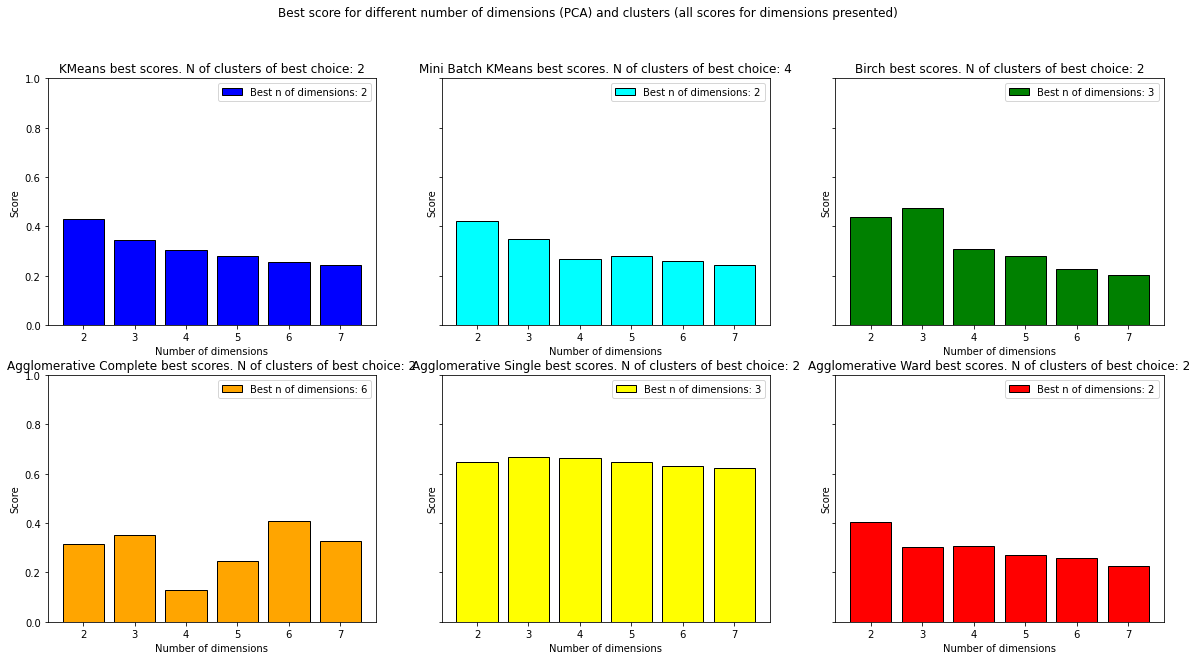

In [0]:
#PCA, df_glove_remove_1
test_reducing_dim(df_glove_remove_1, range(2, 8), 'PCA', range(2, 5), silhouette_score)

$1.$ ramka Glove i TSNE - silhouette dla różnych liczb wymiarów i klastrów:

Testing 5 dimensions
Calculating 2 clusters
Calculating 3 clusters
Calculating 4 clusters
Testing 6 dimensions
Calculating 2 clusters
Calculating 3 clusters
Calculating 4 clusters
Testing 7 dimensions
Calculating 2 clusters
Calculating 3 clusters
Calculating 4 clusters
Testing 8 dimensions
Calculating 2 clusters
Calculating 3 clusters
Calculating 4 clusters
Testing 9 dimensions
Calculating 2 clusters
Calculating 3 clusters
Calculating 4 clusters
Testing 10 dimensions
Calculating 2 clusters
Calculating 3 clusters
Calculating 4 clusters


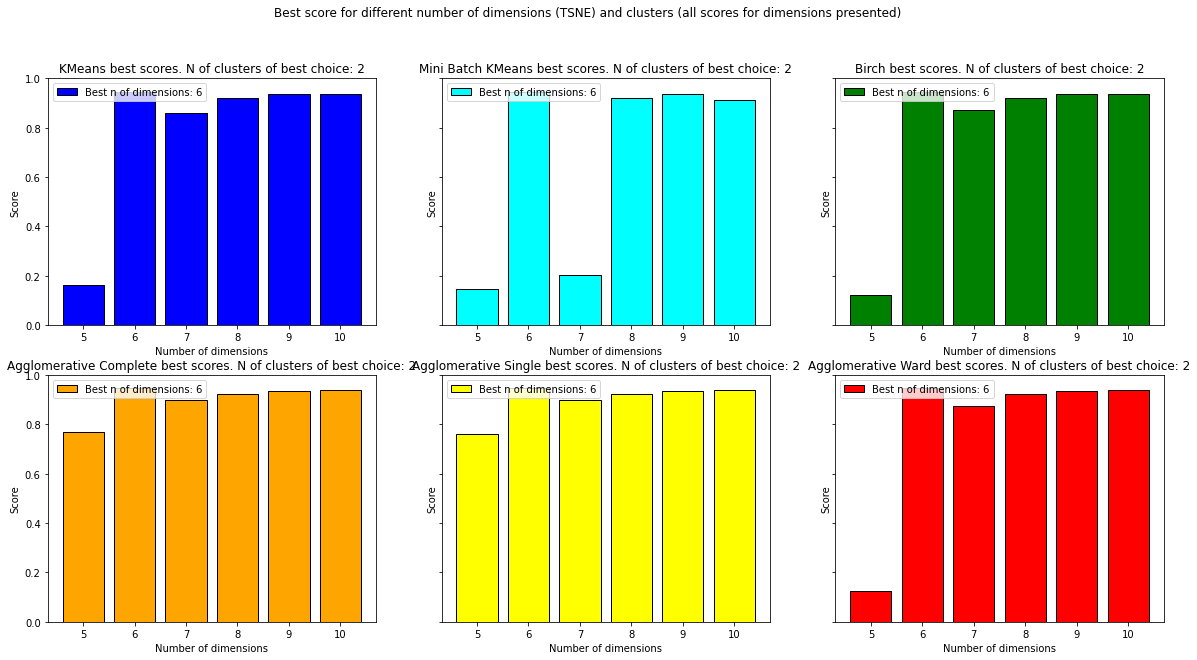

In [0]:
#tsne
test_reducing_dim(df_glove_remove_1, range(5, 11), 'TSNE', range(2, 5), silhouette_score)

Warto zwrócić uwagę na wysokie wyniki Silhouette dla algorytmów używanych na ramkach po TSNE. Najkorzystniejsza liczba klastrów to 2 - wówczas skupienia cechowały się wysokim rozróżnieniem.

Ponownie 1. ramka i TSNE, ale tym razem adjusted mutual info score - na podstawie labelek:

Testing 3 dimensions
Calculating 2 clusters
Calculating 4 clusters
Calculating 6 clusters
Calculating 8 clusters
Testing 4 dimensions
Calculating 2 clusters
Calculating 4 clusters
Calculating 6 clusters
Calculating 8 clusters
Testing 5 dimensions
Calculating 2 clusters
Calculating 4 clusters
Calculating 6 clusters
Calculating 8 clusters
Testing 6 dimensions
Calculating 2 clusters
Calculating 4 clusters
Calculating 6 clusters
Calculating 8 clusters
Testing 7 dimensions
Calculating 2 clusters
Calculating 4 clusters
Calculating 6 clusters
Calculating 8 clusters
Testing 8 dimensions
Calculating 2 clusters
Calculating 4 clusters
Calculating 6 clusters
Calculating 8 clusters
Testing 9 dimensions
Calculating 2 clusters
Calculating 4 clusters
Calculating 6 clusters
Calculating 8 clusters
Testing 10 dimensions
Calculating 2 clusters
Calculating 4 clusters
Calculating 6 clusters
Calculating 8 clusters
Testing 11 dimensions
Calculating 2 clusters
Calculating 4 clusters
Calculating 6 clusters
Calc

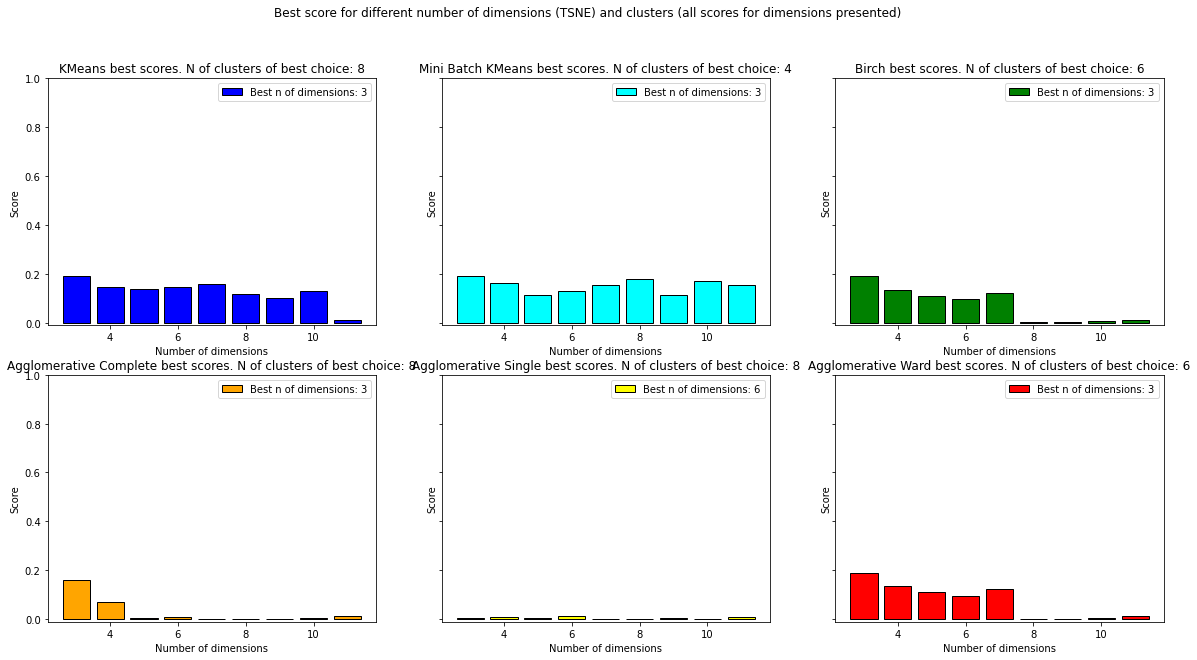

In [0]:
test_reducing_dim(df_glove_remove_1, range(3, 12), 'TSNE', range(2, 9, 2), adjusted_mutual_info_score, true_labels = orig_data.index)

No tu już trochę gorzej, jednak z góry ustaliliśmy 8 oczekiwanych grup w etykietkach. Co gdy zaproponujemy dwie kategorie?

## Podział na dwa skupiska


In [13]:
books_into_two = dict(
    Buddhism = 'Far East',
    TaoTeChing = 'Far East',
    Upanishad = 'Far East',
    YogaSutra = 'Far East',
    BookOfEccleasiasticus = 'Bible',
    BookOfEcclesiastes = 'Bible',
    BookOfProverb = 'Bible',
    BookOfWisdom = 'Bible'
    )
two_labels = [books_into_two[book] for book in orig_data.index]

$1.$ ramka glove i TSNE:

Testing 3 dimensions
Calculating 2 clusters
Testing 4 dimensions
Calculating 2 clusters
Testing 5 dimensions
Calculating 2 clusters
Testing 6 dimensions
Calculating 2 clusters
Testing 7 dimensions
Calculating 2 clusters
Testing 8 dimensions
Calculating 2 clusters
Testing 9 dimensions
Calculating 2 clusters
Testing 10 dimensions
Calculating 2 clusters
Testing 11 dimensions
Calculating 2 clusters


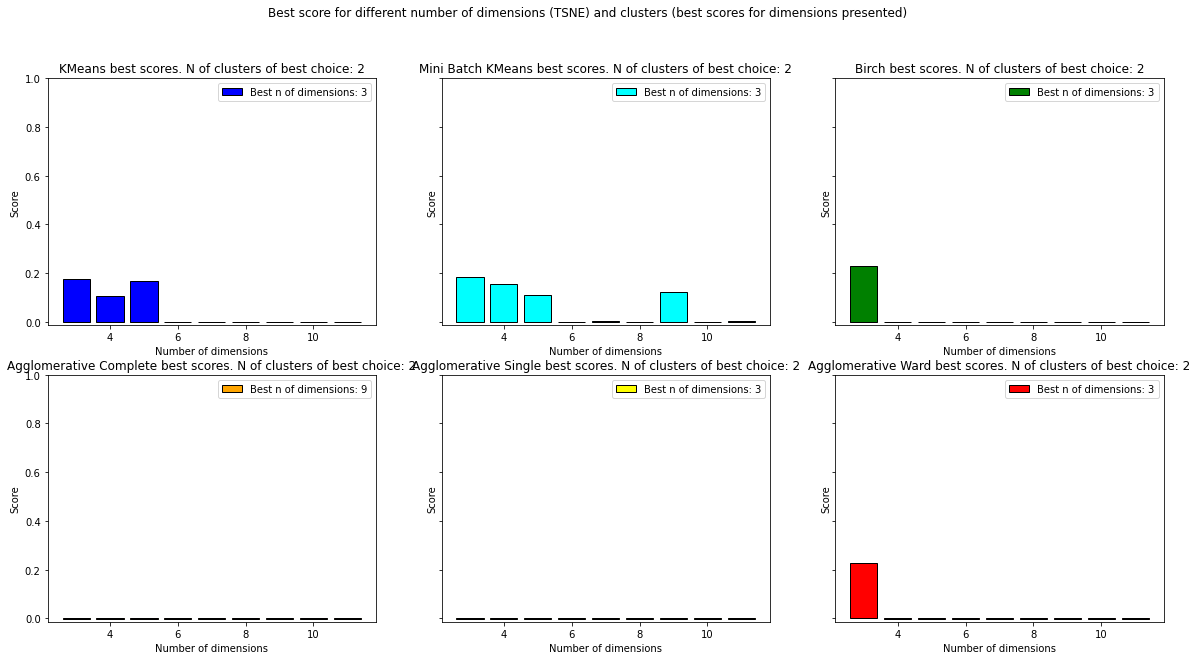

In [0]:
test_reducing_dim(df_glove_remove_1, range(3, 12), 'TSNE', range(2, 3), adjusted_mutual_info_score, true_labels = two_labels)

$1.$ ramka Glove i TSNE, ale z adjusted rand score:

Testing 3 dimensions
Calculating 2 clusters
Testing 4 dimensions
Calculating 2 clusters
Testing 5 dimensions
Calculating 2 clusters
Testing 6 dimensions
Calculating 2 clusters
Testing 7 dimensions
Calculating 2 clusters
Testing 8 dimensions
Calculating 2 clusters
Testing 9 dimensions
Calculating 2 clusters
Testing 10 dimensions
Calculating 2 clusters
Testing 11 dimensions
Calculating 2 clusters


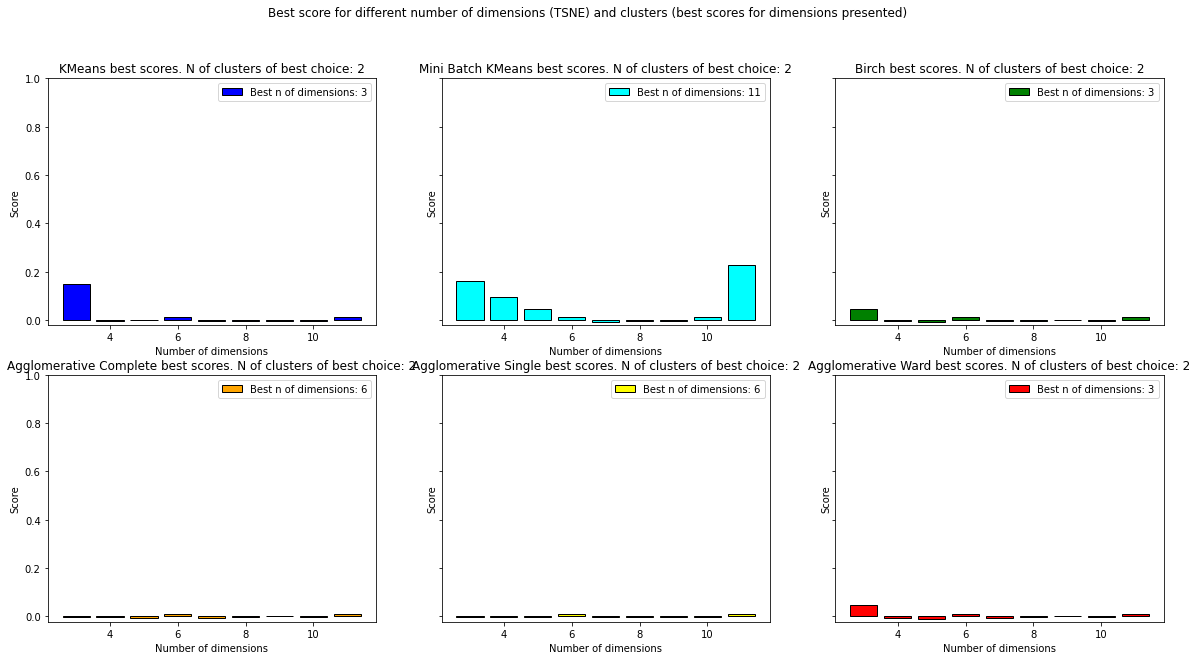

In [0]:
test_reducing_dim(df_glove_remove_1, range(3, 12), 'TSNE', range(2, 3), adjusted_rand_score, true_labels = two_labels)

$1.$ ramka Glove i PCA:

Testing 3 dimensions
Calculating 2 clusters
Testing 4 dimensions
Calculating 2 clusters
Testing 5 dimensions
Calculating 2 clusters
Testing 6 dimensions
Calculating 2 clusters
Testing 7 dimensions
Calculating 2 clusters
Testing 8 dimensions
Calculating 2 clusters
Testing 9 dimensions
Calculating 2 clusters
Testing 10 dimensions
Calculating 2 clusters
Testing 11 dimensions
Calculating 2 clusters


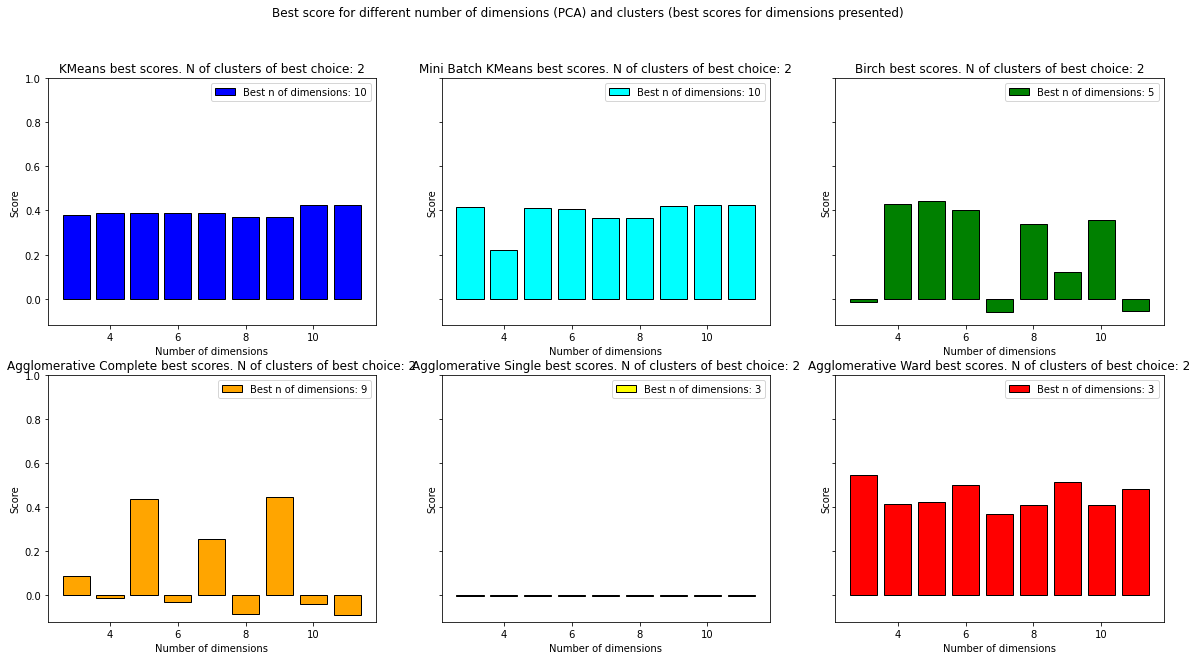

In [0]:
test_reducing_dim(df_glove_remove_1, range(3, 12), 'PCA', range(2, 3), adjusted_rand_score, true_labels = two_labels)

$2.$ ramka Glove i PCA:

Testing 3 dimensions
Calculating 2 clusters
Testing 4 dimensions
Calculating 2 clusters
Testing 5 dimensions
Calculating 2 clusters
Testing 6 dimensions
Calculating 2 clusters
Testing 7 dimensions
Calculating 2 clusters
Testing 8 dimensions
Calculating 2 clusters
Testing 9 dimensions
Calculating 2 clusters
Testing 10 dimensions
Calculating 2 clusters
Testing 11 dimensions
Calculating 2 clusters


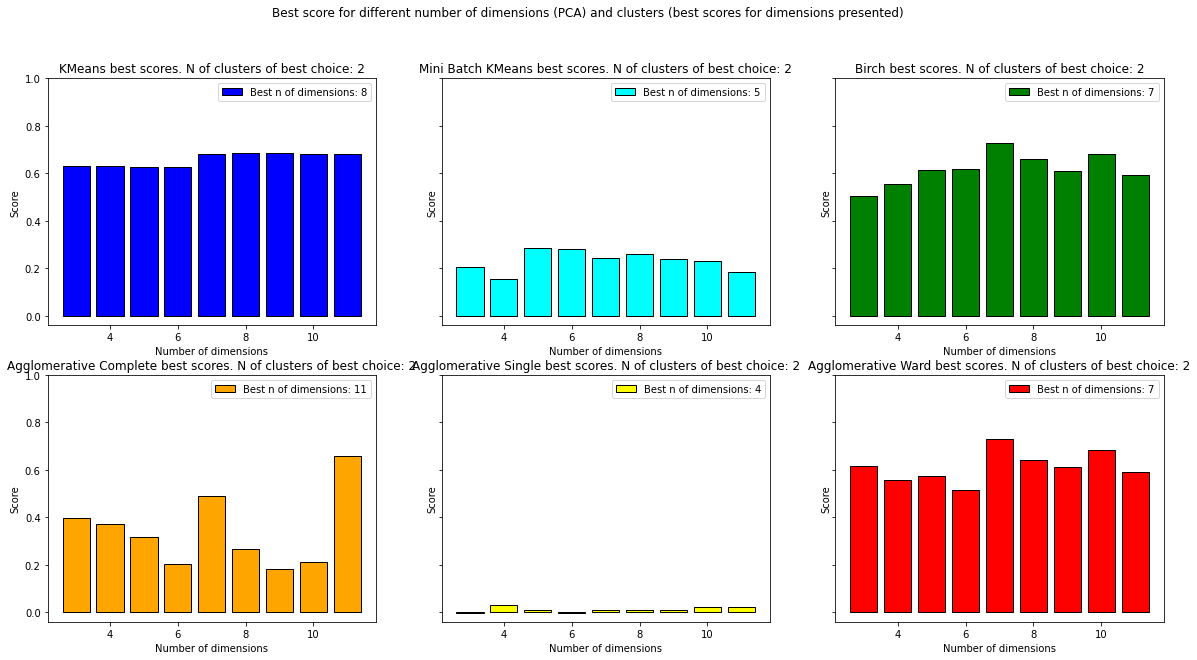

In [0]:
test_reducing_dim(df_glove_remove_2, range(3, 12), 'PCA', range(2, 3), adjusted_rand_score, true_labels = two_labels)

Ramka Tfidf i PCA:

Testing 3 dimensions
Calculating 2 clusters
Testing 4 dimensions
Calculating 2 clusters
Testing 5 dimensions
Calculating 2 clusters
Testing 6 dimensions
Calculating 2 clusters
Testing 7 dimensions
Calculating 2 clusters
Testing 8 dimensions
Calculating 2 clusters
Testing 9 dimensions
Calculating 2 clusters
Testing 10 dimensions
Calculating 2 clusters
Testing 11 dimensions
Calculating 2 clusters


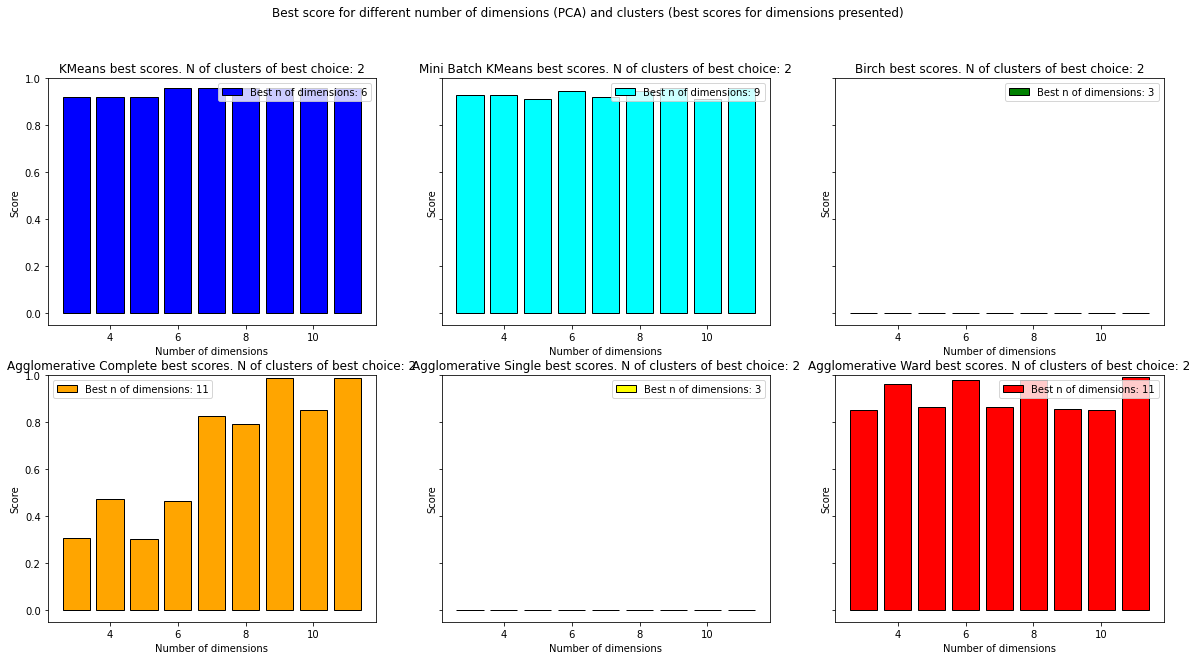

In [0]:
warnings.filterwarnings('ignore')
test_reducing_dim(df_tfidf, range(3, 12), 'PCA', range(2, 3), adjusted_rand_score, true_labels = two_labels)

Algorytm aglomeracyjny z metodą Warda osiągnął bardzo wysoki wynik na ramce po tfidf oraz redukcji wymiarów do 11 przy pomocy PCA.

Jak podobna konfiguracja spisze się w podziale ksiąg na 8?



Testing 3 dimensions
Calculating 8 clusters
Testing 4 dimensions
Calculating 8 clusters
Testing 5 dimensions
Calculating 8 clusters
Testing 6 dimensions
Calculating 8 clusters
Testing 7 dimensions
Calculating 8 clusters
Testing 8 dimensions
Calculating 8 clusters
Testing 9 dimensions
Calculating 8 clusters
Testing 10 dimensions
Calculating 8 clusters
Testing 11 dimensions
Calculating 8 clusters


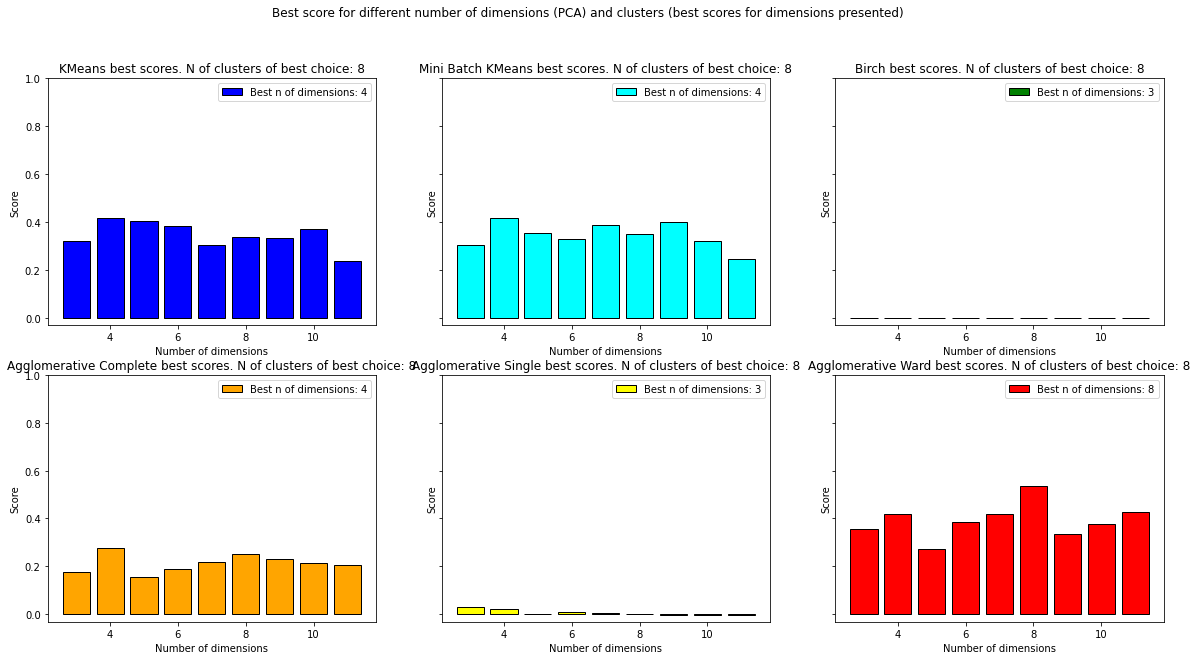

In [0]:
test_reducing_dim(df_tfidf, range(3, 12), 'PCA', range(8, 9), adjusted_rand_score, true_labels = orig_data.index)

Testing 3 dimensions
Calculating 8 clusters
Testing 4 dimensions
Calculating 8 clusters
Testing 5 dimensions
Calculating 8 clusters
Testing 6 dimensions
Calculating 8 clusters
Testing 7 dimensions
Calculating 8 clusters
Testing 8 dimensions
Calculating 8 clusters
Testing 9 dimensions
Calculating 8 clusters
Testing 10 dimensions
Calculating 8 clusters
Testing 11 dimensions
Calculating 8 clusters


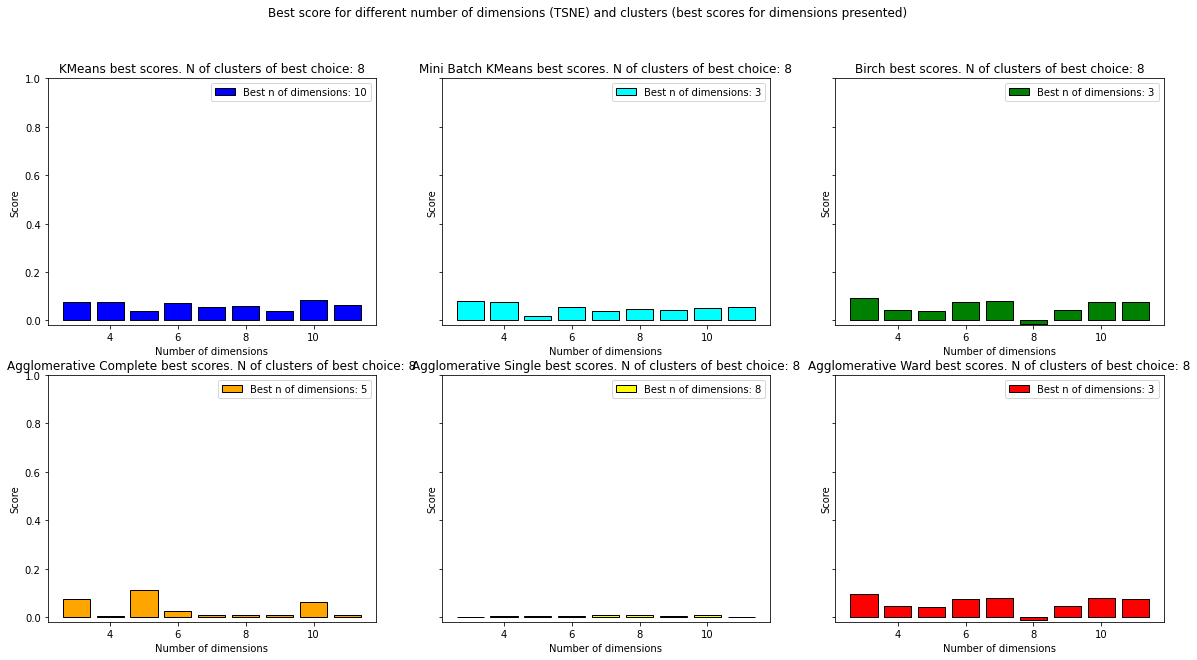

In [0]:
test_reducing_dim(df_tfidf, range(3, 12), 'TSNE', range(8, 9), adjusted_rand_score, true_labels = orig_data.index)

Testing 3 dimensions
Calculating 8 clusters
Testing 4 dimensions
Calculating 8 clusters
Testing 5 dimensions
Calculating 8 clusters
Testing 6 dimensions
Calculating 8 clusters
Testing 7 dimensions
Calculating 8 clusters
Testing 8 dimensions
Calculating 8 clusters
Testing 9 dimensions
Calculating 8 clusters
Testing 10 dimensions
Calculating 8 clusters
Testing 11 dimensions
Calculating 8 clusters


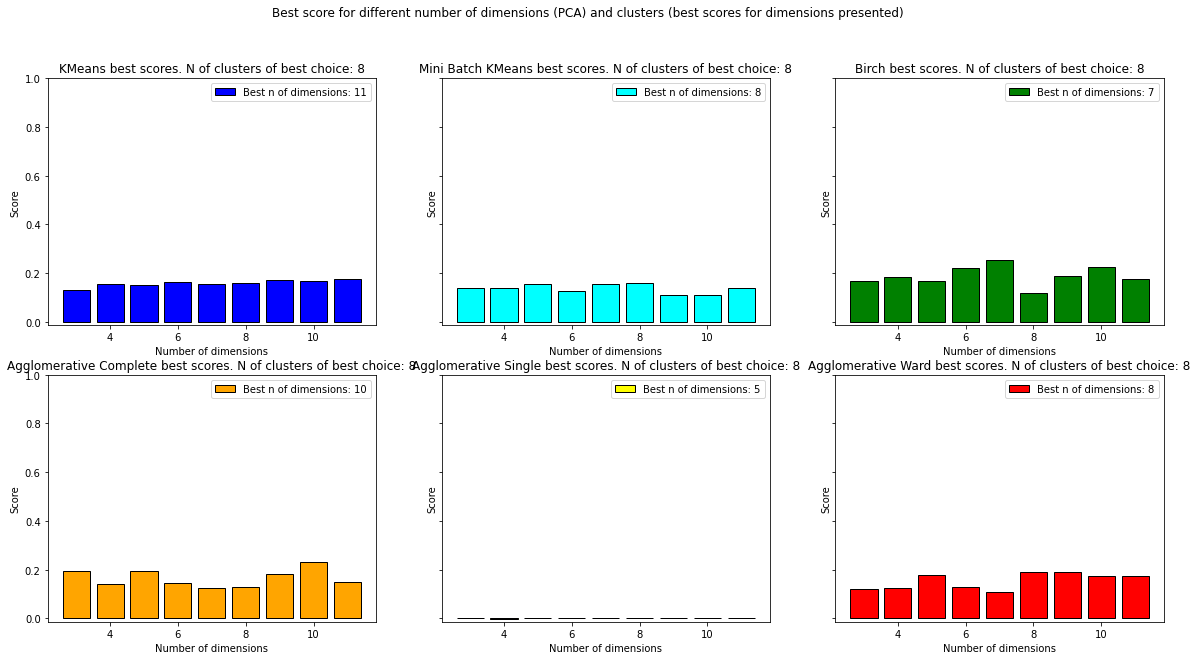

In [0]:
test_reducing_dim(df_glove_remove_1, range(3, 12), 'PCA', range(8, 9), adjusted_rand_score, true_labels = orig_data.index)

Testing 3 dimensions
Calculating 8 clusters
Testing 4 dimensions
Calculating 8 clusters
Testing 5 dimensions
Calculating 8 clusters
Testing 6 dimensions
Calculating 8 clusters
Testing 7 dimensions
Calculating 8 clusters
Testing 8 dimensions
Calculating 8 clusters
Testing 9 dimensions
Calculating 8 clusters
Testing 10 dimensions
Calculating 8 clusters
Testing 11 dimensions
Calculating 8 clusters


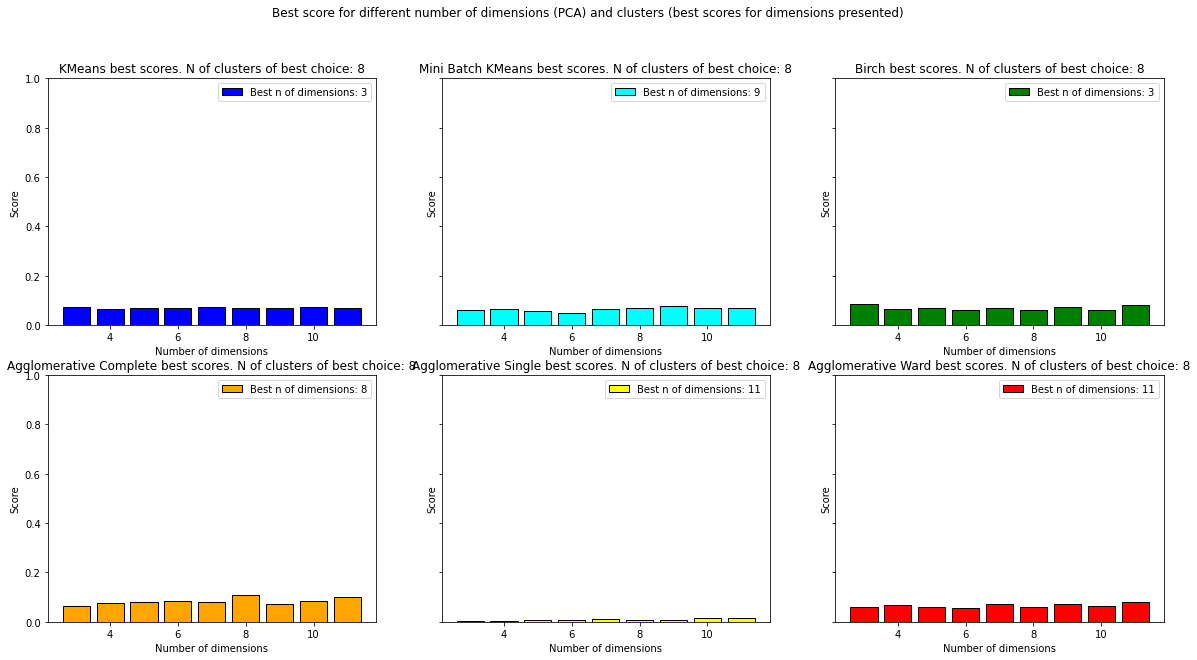

In [0]:
test_reducing_dim(df_glove_remove_2, range(3, 12), 'PCA', range(8, 9), adjusted_rand_score, true_labels = orig_data.index)

Jedynie ramka tfidf po PCA zwróciła sensowne wyniki w okolicy 0.5.


Wróćmy jeszcze do determistycznego algorytmu DBSCAN, który dla 2 wymiarów PCA zwracał 6 klastrów oraz wartość silhouette ponad 0.5.

Sprawdźmy jaka wartość zostanie zmierzona przy pomocy Adjusted Rand Score dla podzialu rozdzialow na 8 ksiag:

Testing 2 dimensions
Testing 3 dimensions


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: UserWarning:

One label (excl. noise) returned for 3 dimensions



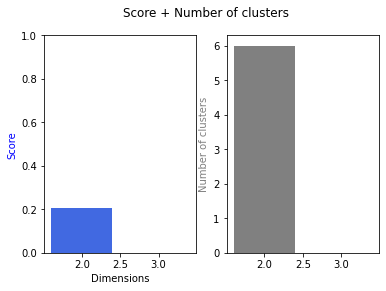

In [0]:
_, _, _, _ = test_dimensions_DBSCAN(df_glove_remove_2, 'PCA', adjusted_rand_score, range(2, 4), true_labels= orig_data.index)

Niska ocena - skupmy się w takim razie na tym, co wyszło nam najlepiej - podział Agglomerative Clusteringiem z metodą Warda na dwie grupy na ramce tfidf po PCA do 11 wymiarów. 


In [14]:
pca11 = PCA(11, random_state=10)
pca3 = PCA(3, random_state=10)
tsne3 = TSNE(3, random_state=98)

data = df_tfidf
labels = two_labels
title = '2 clusters on 11-dimension tfidf data frame'
shape_dict = {'Far East': 'circle-open', 'Bible': 'x'}
color_dict = {0: 'red', 1: 'blue'}
transf_data = pca11.fit_transform(data)
fig = make_subplots(1, 2,
                    specs=[[{'type': 'scene'}, {'type': 'scene'}]],
                    column_titles = ['Principal component analysis (PCA)', 't-distributed Stochastic Neighbor Embedding (TSNE)'])
df = pd.DataFrame(transf_data)
agg_model = AgglomerativeClustering(n_clusters = 2, linkage = 'ward')
colors = agg_model.fit_predict(df)
transf_df = pca3.fit_transform(df)
df = pd.DataFrame(transf_data)
fig.add_trace(go.Scatter3d(x = df.iloc[:,0], y = df.iloc[:,1], z = df.iloc[:,2],
                                mode = 'markers', marker = dict(size = 1.5, symbol = [shape_dict[lab] for lab in labels], color = [color_dict[c] for c in colors])), row = 1, col = 1)
transf_data2 = tsne3.fit_transform(df)
df2 = pd.DataFrame(transf_data2)
fig.add_trace(go.Scatter3d(x = df2.iloc[:,0], y = df2.iloc[:,1], z = df2.iloc[:,2],
                               mode = 'markers', marker = dict(size = 1.5, symbol = [shape_dict[lab] for lab in labels], color = [color_dict[c] for c in colors])), row = 1, col = 2)
fig.update_layout(title = title + ': Presenting after reducing the dimensions by:', showlegend = False)
fig.show()

##Problem z legendą: ksztalty oznaczaja bliski/daleki wschod, kolory labelki po klasteryzacji


Z podziałem na 8 skupień najlepiej również sobie poradził algorytm aglomeratywny z metodą Warda po PCA do 8 wymiarów na ramce tfidf


In [15]:
pca8 = PCA(8, random_state=10)
pca3 = PCA(3, random_state=10)
tsne3 = TSNE(3, random_state=98)

data = df_tfidf
labels = orig_data.index
title = '8 clusters on 8-dimension tfidf data frame'
shape_dict = {'BookOfEccleasiasticus': 'x', 'BookOfEcclesiastes': 'circle-open', 'BookOfProverb': 'square-open', 'BookOfWisdom': 'diamond-open',
                'Buddhism': 'circle', 'TaoTeChing': 'square', 'Upanishad': 'diamond', 'YogaSutra': 'cross'}
transf_data = pca8.fit_transform(data)
fig = make_subplots(1, 2,
                    specs=[[{'type': 'scene'}, {'type': 'scene'}]],
                    column_titles = ['Principal component analysis (PCA)', 't-distributed Stochastic Neighbor Embedding (TSNE)'])
df = pd.DataFrame(transf_data)
agg_model = AgglomerativeClustering(n_clusters = 8, linkage = 'ward')
colors = agg_model.fit_predict(df)
transf_df = pca3.fit_transform(df)
df = pd.DataFrame(transf_data)
fig.add_trace(go.Scatter3d(x = df.iloc[:,0], y = df.iloc[:,1], z = df.iloc[:,2],
                                mode = 'markers', marker = dict(size = 1.5, symbol = [shape_dict[lab] for lab in labels], color = colors)), row = 1, col = 1)
transf_data2 = tsne3.fit_transform(df)
df2 = pd.DataFrame(transf_data2)
fig.add_trace(go.Scatter3d(x = df2.iloc[:,0], y = df2.iloc[:,1], z = df2.iloc[:,2],
                               mode = 'markers', marker = dict(size = 1.5, symbol = [shape_dict[lab] for lab in labels], color = colors)), row = 1, col = 2)
fig.update_layout(title = title + ': Presenting after reducing the dimensions by:', showlegend = False)
fig.show()

##Problem z legendą: ksztalty oznaczaja bliski/daleki wschod, kolory labelki po klasteryzacji
## Plusiki - YogaSutra - najlepiej oddzielone

## Podsumowanie

Krótkie streszczenie tego etapu i prac:
 - zaprezentowaliśmy oryginalne dane na płaszczyźnie kartezjańskiej po zredukowaniu wymiarów do dwóch przy pomocy PCA  i tSNE
 - zaprezentowaliśmy każdą z ramek danych w trójwymiarze po redukcji wymiarów do 3 przy pomocy obu narzędzi
 - zbadaliśmy działanie algorytmu klasteryzującego DBSCAN po redukcji wymiarów do kilku(nastu)
 - miarą silhouette zbadaliśmy działanie 6 algorytmów klasteryzujących na całych ramkach danych dla kilku(nastu) skupień. Badane algorytmy to: 
  - KMeans
  - Mini Batch KMeans
  - Birch
  - Agglomerative Clustering z metodami:
    - simple
    - complete
    - Ward
 - przy pomocy miar silhouette oraz adjusted_mutual_info i adjusted_rand (korzystających z przypisanych etykiet) zbadaliśmy działanie powyższych algorytmów klasteryzujących dla różnych liczby zredukowanych wymiarów (redukcja zdecydowanie podniosła efektywność algorytmów) oraz klastrów. Efekty:
   - Po redukcji TSNE klasteryzacja na 1. ramce glove osiągała wysokie wyniki silhouette - skupienia zdecydowanie różniły się od siebie, lecz wyniki miar korzystających z prawdziwych etykiet nie były najlepsze
   - Po podziale etykiet na dwie grupy - księgi bliskiego i dalekiego wschodu, uzyskaliśmy bardzo wysoką skuteczność przy klasteryzacji ksiąg. Agglomerative Clustering z metodą Warda niepoprawnie przypisał tylko jedną obserwację (adjusted_rand ~ 1)
   - Podobnego wniosku nie można wyciągnąć przy podziale na 8 ksiąg - widocznie nie różnią się one od siebie wystarczająco. (adjusted_rand ~ 0.6)
 - DBSCAN, dzielący księgi na 6 klastrów, pomimo wartości silhouette >0.5, osiągnął tylko 0.2 w pomiarze adjusted_rand
 - klasteryzacja rozdziałów została zaprezentowana zarówno przy najlepszym podziale na 2 grupy jak i najlepszym podziale na 8
 - PCA okazało się być lepszym narzędziem zarówno do wizualizacji jak i klasteryzacji


Porównanie wyników bez redukcji wymiarów znajduje się w poprzednim kamieniu milowym.